In [2]:
import torch
import logging

import torch.nn as nn
import torch.optim as o
import torch.utils.data as d
import torch.nn.functional as F

from tqdm import tqdm
import seaborn as sns
import transformers as T

from datasets import DailyDialog
from models import BERTClassifier

In [3]:
logging.basicConfig(level=logging.INFO)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
MAX_LEN = 50
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
BATCH_SIZE = 1000

In [5]:
tokenizer = T.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,model_max_length=MAX_LEN)
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [6]:
def target_process(data):
    uniques = set(data)
    return data, {"categories" : uniques}

def data_process(data):
    out = []
    lens = []
    for i in data:
        i = i.strip('". ')
        i = tokenizer.tokenize(i)
        

        lens.append(len(i))
        i = tokenizer.convert_tokens_to_ids(i)
        if len(i) > MAX_LEN:
            i = i[:MAX_LEN]
        i += [PAD_INDEX] * (MAX_LEN - len(i))
        out.append(torch.tensor(i))
    max_len = max(lens)
    return out, {"max_len" : max_len, "lengths" : lens}

In [7]:
dataset = DailyDialog()
dataset.load()
dataset.train_preprocess(data_process)
dataset.test_preprocess(target_process)

In [8]:
lens = dataset.args["train"]["lengths"]

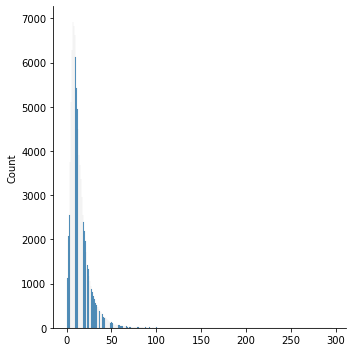

In [9]:
sns.displot(lens)

In [10]:
model = BERTClassifier()
criterion = o.Adam(model.parameters(), lr=2e-5)
NUM_EPOCHS = 5
eval_interval = len(dataset) // 2
SAVE_PATH = 'save'
best_valid = float("Inf")

In [11]:
dataloader = d.DataLoader(dataset, batch_size=BATCH_SIZE)

for x_batch, y_batch in dataloader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([1000, 50]) torch.Size([1000])


In [12]:
running_loss = 0.00
valid_running_loss = 0.00
global_step = 0
train_loss_list = []
valid_loss_list = []
global_steps_list = []

validate = False

In [13]:
model.train()

for epoch in range(NUM_EPOCHS):
    for x_batch, y_batch in tqdm(dataloader):
        print("Predicting")
        loss = model(x_batch)

        print("Initialising Optimizer")
        optimizer.zero_grad()

        print("Computing Loss")
        loss.backward()

        print("Optimising")
        optimizer.step()

        running_loss += loss.item()
        global_step += 1

        if (validate) and (global_step % eval_interval == 0):
            model.eval()
            with torch.no_grad():
                for x_val_batch, y_val_batch in valid_dataloader:
                    loss, _ = model(x_val_batch, y_val_batch)
                    valid_running_loss += loss.item()

            average_train_loss = running_loss / eval_interval
            average_valid_loss = valid_running_loss / len(valid_dataloader)

            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)

            global_step_list.append(global_step)

            # resetting loss values
            running_loss = 0.00
            valid_running_loss = 0.00

            model.train()

            # print progress
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                    .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                            average_train_loss, average_valid_loss))

            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

        save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        print('Finished Training!')
        

  0%|          | 0/103 [00:00<?, ?it/s]Predicting
Masked
  0%|          | 0/103 [00:24<?, ?it/s]


KeyboardInterrupt: 